## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [1]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [2]:
# Download MNIST
transform = transforms.Compose([
    transforms.ToTensor(), # Convert PIL Image or numpy.ndarray to Tensor
    # Add other transformations if needed, e.g., transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',  # Directory where the dataset will be stored
    train=True,     # Specifies this is the training set
    download=True,  # Downloads the dataset if it's not already there
    transform=transform # Applies the defined transformations
)
test_dataset = torchvision.datasets.MNIST(
    root='./data',  # Directory where the dataset will be stored
    train=False,    # Specifies this is the test set
    download=True,  # Downloads the dataset if it's not already there
    transform=transform # Applies the defined transformations
)
# The 'background' parameter is not a standard argument for torchvision.datasets.MNIST.
# If a custom dataset or specific variant of MNIST was intended, it would need custom handling.
# For standard MNIST, `download=True` handles fetching the data.

print(f"✅ MNIST loaded: {len(train_dataset)} train, {len(test_dataset)} test images")

# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

100%|██████████| 9.91M/9.91M [00:00<00:00, 44.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.11MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.80MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.69MB/s]

✅ MNIST loaded: 60000 train, 10000 test images


In [3]:
# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

task_definitions = {
    'A': [0, 1],
    'B': [2, 3],
    'C': [4, 5],
    'D': [6, 7],
    'E': [8, 9]
}
from collections import defaultdict
import random

def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):
    """
    Create train, support, and query sets for a specific task.
    """

    train_data = []
    support_data = []
    query_data = []

    # Map original labels → task-local labels (e.g. [2,3] → {2:0, 3:1})
    label_map = {cls: i for i, cls in enumerate(task_classes)}

    # Collect indices per class
    class_indices = defaultdict(list)
    for i, (image, label) in enumerate(dataset):
        if label in task_classes:
            class_indices[label].append(i)

    for class_label in task_classes:
        indices = class_indices[class_label]
        random.shuffle(indices)

        required = n_train + n_support + n_query
        if len(indices) < required:
            raise ValueError(
                f"Not enough samples for class {class_label}. "
                f"Required={required}, Available={len(indices)}"
            )

        current_idx = 0

        # Training data
        for _ in range(n_train):
            image, label = dataset[indices[current_idx]]
            train_data.append((image, label_map[label]))
            current_idx += 1

        # Support data
        for _ in range(n_support):
            image, label = dataset[indices[current_idx]]
            support_data.append((image, label_map[label]))
            current_idx += 1

        # Query data
        for _ in range(n_query):
            image, label = dataset[indices[current_idx]]
            query_data.append((image, label_map[label]))
            current_idx += 1

    return train_data, support_data, query_data


In [ ]:
# Test the function

train_A, support_A, query_A = create_task_datasets(train_dataset, task_definitions['A'])
print(f"Task A - Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")

Task A - Train: 30, Support: 10, Query: 20


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [4]:
# think on the architecture of the model as discussed in class
#general flow -> convolution->relu->maxpooling and so on , in the end some fully connected layers then final classification
# Refer to the 60 minute pytorch implementation section of 'neural networks'


#Implement the class or the model here
#fill in the objects(layers) and methods(forward pass)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # Output: (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: (32, 14, 14)
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (64, 7, 7)
        )
        # Calculate the size of the flattened output after conv layers
        # For MNIST (28x28), after two 2x2 max pools, it becomes 7x7
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128), # Flatten 64*7*7 feature maps
            nn.ReLU(),
            nn.Linear(128, num_classes) # Output layer for classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x


Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def train_model(model, dataloader, epochs=5, lr=1e-3):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")


In [ ]:
# -------- PART 1: Train from scratch on Task A (0 & 1) --------

taskA_train, taskA_support, taskA_query = create_task_datasets(
    train_dataset,
    task_definitions['A'],
    n_train=1000,   # large dataset
    n_support=5,
    n_query=10
)

taskA_train_loader = torch.utils.data.DataLoader(
    taskA_train, batch_size=64, shuffle=True
)

model_A = SimpleCNN(num_classes=2).to(device)

print("Training Task A model from scratch...")
train_model(model_A, taskA_train_loader, epochs=5)

# Save model
torch.save(model_A.state_dict(), "model_taskA_from_scratch.pth")


Training Task A model from scratch...
Epoch 1/5, Loss: 0.1545
Epoch 2/5, Loss: 0.0156
Epoch 3/5, Loss: 0.0064
Epoch 4/5, Loss: 0.0043
Epoch 5/5, Loss: 0.0063


In [ ]:
# -------- PART 2.1: Random init + fine-tune on Task A support --------

taskA_support_loader = torch.utils.data.DataLoader(
    taskA_support, batch_size=5, shuffle=True
)

model_A_ft = SimpleCNN(num_classes=2).to(device)

print("Fine-tuning randomly initialized model on Task A support set...")
train_model(model_A_ft, taskA_support_loader, epochs=10, lr=1e-4)

torch.save(model_A_ft.state_dict(), "model_taskA_finetuned_from_random.pth")


Fine-tuning randomly initialized model on Task A support set...
Epoch 1/10, Loss: 0.6944
Epoch 2/10, Loss: 0.6663
Epoch 3/10, Loss: 0.6528
Epoch 4/10, Loss: 0.6321
Epoch 5/10, Loss: 0.6176
Epoch 6/10, Loss: 0.5995
Epoch 7/10, Loss: 0.5819
Epoch 8/10, Loss: 0.5653
Epoch 9/10, Loss: 0.5445
Epoch 10/10, Loss: 0.5263


In [ ]:
# -------- PART 2.2: Fine-tune Task A model on Task B --------

taskB_train, taskB_support, _ = create_task_datasets(
    train_dataset,
    task_definitions['B']
)

taskB_support_loader = torch.utils.data.DataLoader(
    taskB_support, batch_size=5, shuffle=True
)

# Load Task A trained model
model_B = SimpleCNN(num_classes=2).to(device)
model_B.load_state_dict(torch.load("model_taskA_from_scratch.pth"))

# Freeze convolution layers
for param in model_B.conv_layers.parameters():
    param.requires_grad = False

print("Fine-tuning Task A model on Task B support set...")
train_model(model_B, taskB_support_loader, epochs=10, lr=1e-4)

torch.save(model_B.state_dict(), "model_taskB_finetuned_from_taskA.pth")


Fine-tuning Task A model on Task B support set...
Epoch 1/10, Loss: 3.0979
Epoch 2/10, Loss: 2.8391
Epoch 3/10, Loss: 2.6931
Epoch 4/10, Loss: 2.6343
Epoch 5/10, Loss: 2.4788
Epoch 6/10, Loss: 2.3823
Epoch 7/10, Loss: 2.3245
Epoch 8/10, Loss: 2.2696
Epoch 9/10, Loss: 2.2132
Epoch 10/10, Loss: 2.1837


In this step we will keep convulation layers as it stores features of images.

In [ ]:
# -------- PART 3.1: Train on all digits (0–9) --------

full_train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

model_all = SimpleCNN(num_classes=10).to(device)

print("Training model on all 10 digits...")
train_model(model_all, full_train_loader, epochs=5)

torch.save(model_all.state_dict(), "model_all_digits.pth")


Training model on all 10 digits...
Epoch 1/5, Loss: 0.1766
Epoch 2/5, Loss: 0.0493
Epoch 3/5, Loss: 0.0344
Epoch 4/5, Loss: 0.0257
Epoch 5/5, Loss: 0.0201


In [ ]:
# -------- PART 3.2: Fine-tune 10-class model to binary Task A --------

taskA_support_loader = torch.utils.data.DataLoader(
    taskA_support, batch_size=5, shuffle=True
)

model_binary = SimpleCNN(num_classes=2).to(device)

# Load pretrained weights except final layer
pretrained_dict = torch.load("model_all_digits.pth")
model_dict = model_binary.state_dict()

pretrained_dict = {k: v for k, v in pretrained_dict.items()
                   if k in model_dict and "fc_layers.2" not in k}

model_dict.update(pretrained_dict)
model_binary.load_state_dict(model_dict)

# Freeze feature extractor
for param in model_binary.conv_layers.parameters():
    param.requires_grad = False

print("Fine-tuning 10-class pretrained model to Task A binary classifier...")
train_model(model_binary, taskA_support_loader, epochs=10, lr=1e-4)


Fine-tuning 10-class pretrained model to Task A binary classifier...
Epoch 1/10, Loss: 2.1227
Epoch 2/10, Loss: 1.9526
Epoch 3/10, Loss: 1.7782
Epoch 4/10, Loss: 1.6359
Epoch 5/10, Loss: 1.4967
Epoch 6/10, Loss: 1.3471
Epoch 7/10, Loss: 1.1946
Epoch 8/10, Loss: 1.0895
Epoch 9/10, Loss: 0.9577
Epoch 10/10, Loss: 0.8516


In this step we will keep convulation layers and FC1 as it stores features of images. It also removes 10 outputs and replaces it with 2 output FC2.

At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


In [17]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, precision, recall, f1

In [15]:
def train_model_with_logging(model, dataloader, epochs=5, lr=1e-3):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    epoch_losses = []

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")

    return epoch_losses


In [ ]:
taskA_query_loader = torch.utils.data.DataLoader(
    taskA_query, batch_size=32, shuffle=False
)


In [ ]:
model_A = SimpleCNN(num_classes=2).to(device)
model_A.load_state_dict(torch.load("model_taskA_from_scratch.pth"))

metrics_A = evaluate_model(model_A, taskA_query_loader)


In [ ]:
model_A_ft = SimpleCNN(num_classes=2).to(device)
model_A_ft.load_state_dict(torch.load("model_taskA_finetuned_from_random.pth"))

metrics_A_ft = evaluate_model(model_A_ft, taskA_query_loader)


In [ ]:
model_B = SimpleCNN(num_classes=2).to(device)
model_B.load_state_dict(torch.load("model_taskB_finetuned_from_taskA.pth"))

metrics_transfer = evaluate_model(model_B, taskA_query_loader)


In [ ]:
metrics_pretrained = evaluate_model(model_binary, taskA_query_loader)


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
loss_A = train_model_with_logging(model_A, taskA_train_loader)
loss_A_ft = train_model_with_logging(model_A_ft, taskA_support_loader)
loss_transfer = train_model_with_logging(model_B, taskB_support_loader)
loss_pretrained = train_model_with_logging(model_binary, taskA_support_loader)


Epoch 1/5 | Loss: 0.0009
Epoch 2/5 | Loss: 0.0002
Epoch 3/5 | Loss: 0.0000
Epoch 4/5 | Loss: 0.0000
Epoch 5/5 | Loss: 0.0000
Epoch 1/5 | Loss: 0.5294
Epoch 2/5 | Loss: 0.4238
Epoch 3/5 | Loss: 0.2114
Epoch 4/5 | Loss: 0.1073
Epoch 5/5 | Loss: 0.0658
Epoch 1/5 | Loss: 2.5028
Epoch 2/5 | Loss: 1.8345
Epoch 3/5 | Loss: 1.3184
Epoch 4/5 | Loss: 0.7303
Epoch 5/5 | Loss: 0.6921
Epoch 1/5 | Loss: 0.5589
Epoch 2/5 | Loss: 0.1139
Epoch 3/5 | Loss: 0.0312
Epoch 4/5 | Loss: 0.0107
Epoch 5/5 | Loss: 0.0052


In [ ]:
#Analysis and Plots

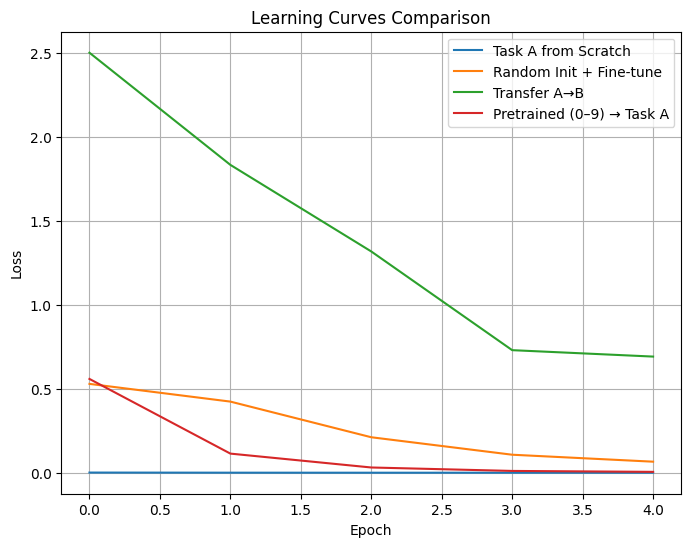

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(loss_A, label="Task A from Scratch")
plt.plot(loss_A_ft, label="Random Init + Fine-tune")
plt.plot(loss_transfer, label="Transfer A→B")
plt.plot(loss_pretrained, label="Pretrained (0–9) → Task A")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves Comparison")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pandas as pd

results = pd.DataFrame({
    "Method": [
        "Task A from Scratch",
        "Random Init + Fine-tune",
        "Transfer Learning (A→B)",
        "Pretrained 0–9 → Task A"
    ],
    "Accuracy": [
        metrics_A[0],
        metrics_A_ft[0],
        metrics_transfer[0],
        metrics_pretrained[0]
    ],
    "Precision": [
        metrics_A[1],
        metrics_A_ft[1],
        metrics_transfer[1],
        metrics_pretrained[1]
    ],
    "Recall": [
        metrics_A[2],
        metrics_A_ft[2],
        metrics_transfer[2],
        metrics_pretrained[2]
    ],
    "F1 Score": [
        metrics_A[3],
        metrics_A_ft[3],
        metrics_transfer[3],
        metrics_pretrained[3]
    ]
})

print(results)


                    Method  Accuracy  Precision  Recall  F1 Score
0      Task A from Scratch      1.00        1.0     1.0  1.000000
1  Random Init + Fine-tune      0.95        1.0     0.9  0.947368
2  Transfer Learning (A→B)      1.00        1.0     1.0  1.000000
3  Pretrained 0–9 → Task A      0.50        0.5     0.8  0.615385


Some Theoritical Questions :

1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



1. Transfer learning from Task A to Task B performs best because the pretrained model already captured digit features, allowing effective adaptation using a small support set, whereas random initialization lacks prior knowledge and overfits easily.
2. During 10-class training the model was learning and developing its layers extracting features and mapping them to numbers. During fine tuning, the model focuses more on finding the important distinguising features between two required fields for it to do binary classification.
3. The convolutional layers of the digit classifier learn general visual features such as edges, strokes, and curves, which are also useful for letter recognition. the convolutional layers can be reused as a feature extractor, the final fully connected layers are replaced with a new binary classifier, and the model is fine-tuned on the letter dataset.
4. We have not implemented meta learning yet, only got to know that we can use a layer of nn to extrace general features for performing similar tasks.

# ALL THE BEST !